<a href="https://colab.research.google.com/github/zenodante/AFMTools/blob/master/2DRAFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift Correction

During all electron microscopy experiments the sample stage drifts. The most prominent reason for drift is high temperature but it can also be due to vibrations in the room/microscope, or other reasons. Most of the time this is not a problem, however sample drift becomes a big issue when exposure times are long and the sample is held at a high temperature. Correcting for drift is vital when looking at images of the same size with a focus on the position of objects in the images. Drift can be seen as a consistent motion through a series of images. This means that the whole image, and hence, all the particles, move in the same direction. However, the direction of motion can change throughout the experiment. We know it is the images and not the particles moving because the particles always move the same amount in the same direction. 

Drift correction is extremely important because if it is not done correctly it can cause problems in all future notebooks. Without proper drift correction we are not able to track particles and no information can be gained from the datasets. At the end of this notebook we check the drift correction by making a movie of the cropped images. We do this by looking for black borders on each frame. 

## Import necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import skimage
from skimage import measure
from skimage.transform import *
from skimage.measure import label
import time
import pandas as pd
import os
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from scipy import stats
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

## Load image set to begin processing

Load the file that we created in our current working directory to start drift correction. Store the loaded data in the variable im. We use `mmap_mode` to map the memory addresses for faster access. We do this to fix issues with computer RAM and may or may not be necessary.



In [ ]:
!gdown --id 1Lelp1sSXeNtDpv0eIAnwak4dX4sGVb1T
im = np.load('/content/sample_data_small.npy',mmap_mode='r+')

### If loading a local dataset, use something like the following line
#im = np.load('/path/to/image_data.npy',mmap_mode='r+')

Downloading...
From: https://drive.google.com/uc?id=1Lelp1sSXeNtDpv0eIAnwak4dX4sGVb1T
To: /content/sample_data_small.npy
839MB [00:03, 214MB/s]


## Pick up after this step if not the first time

Load the file that we created in our current working directory to start drift correction. Store the loaded data in the variable im. We use `mmap_mode` to map the memory addresses for faster access. We do this to fix issues with computer RAM and may or may not be necessary.

In [ ]:
im = np.load('../ExtraDrive3/BNL_032020/03052020/800/800C_video_float32/800C_video_float32.npy',mmap_mode='r+')

Plot an image in the dataset to ensure it was loaded correctly.

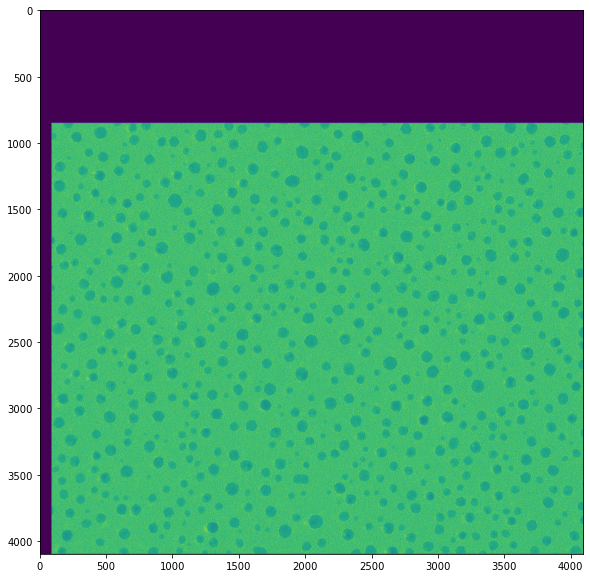

In [ ]:
f,a = plt.subplots(figsize=(10,10)) 
a.imshow(im[-1],plt.cm.gray) 

## Intensity Normalization

The intensity of all images needs to be normalized on the same range for a fair comparison.  You can imagine that some images may appear darker than others even though they capture the same objects - we can correct for the relative intensity change by scaling all the intensity data between 0 and 1.

The rescale function defined below helps to remove line noise and consistent contrast change across an image. The norm function shifts these scaled values so that they are distributed between 0 and 1.

The images are first rescaled then normalized. We use the rescale function to transform the image intensity values to be normally distributed about the mean intensity. We then use norm to shift the data to be in the max and min values. We do this so they all have the same mean and are in the same range.

In [ ]:
def rescale(im): 
    m = np.mean(im)
    s = np.std(im)
    return (im - m) / s  

def norm(im):
    return (im - np.min(im)) / (np.max(im) - np.min(im)) 

for i in range(len(im)):
    if i % 100 == 0:
        print(i)
    im[i] = norm(rescale(im[i])) 

0
100
200
300
400
500
600
700


## Cross correlation using skimage functions

The `register_translation` function below measures the difference between an image and the first image in the time series. After the shift here is measured, we can shift the entire image by the same amount to reduce drift throughout a data set.

The `AffineTransform` function shifts the image by the amount measured by `register_translation`.

This works as long as there are enough features in an image to compare them to each other. If there was only one particle and the image was blurry this method would not work. 

0 / 755
100 / 755
200 / 755
300 / 755
400 / 755
500 / 755
600 / 755
700 / 755


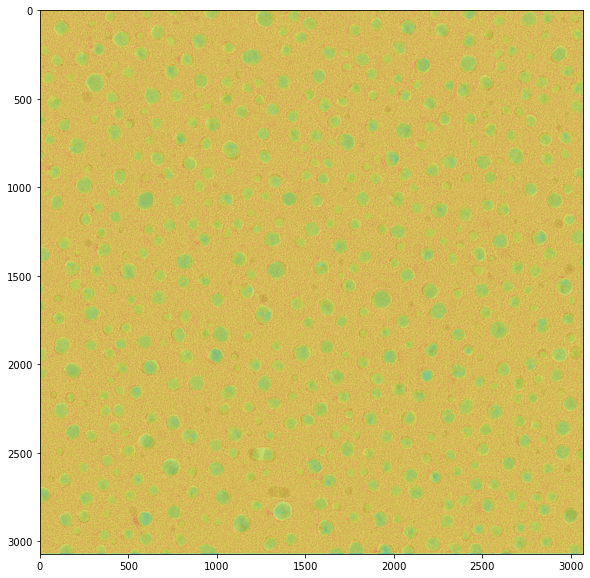

In [ ]:
for i in range(len(im)):
    if i % 100 == 0:
        print('{} / {}'.format(i,len(im)))
    if i == 0:
        continue
    t0 = im[0] 
    t1 = im[i]
    shift,e,d = register_translation(t0,t1)
    vec = AffineTransform(translation=[-shift[1],-shift[0]])
    im[i] = warp(t1,vec)

## Cropping Dimensions

The next step is to create a movie of the images in the dataset that are stored in the variable im. From this movie we can see where the images have shifted by looking at the black borders on the edges. We must determine the best values to crop the images in order to remove all black borders by using a guess and check method. After choosing these values to crop the images, make a new movie of the cropped images to check for any remaining black border. Once these values are determined we can save the drift corrected images by adding the constraints to the variable im. To make segmentation at later steps easier crop the images so the shape is divisible by 512.

<font color='Red'>The following cell can be used to save the drift-corrected image set.  Do not run this is you are using the provided sample data.</font> 

<font color='Green'>ACTION: If using, add cropping dimensions before saving in the form [:,y constraint,x constraint]. </font> 

In [ ]:
np.save('800C_video_float32_driftcorrect2.npy',im[:,1024:,706:3778]) 

## Sample Code to Make Movie

In a terminal, run: ffmpeg -framerate 25 -pix_fmt yuv420p -i movie_frames/%04d.png -vcodec libx264 output_movie.mp4 

This will produce a movie called output_movie.mp4 with text displaying the time at a framerate of 25. <font color='green'>

ACTION (OPTIONAL): You can reduce the framerate number to 10 or 5 to be slower. </font> 

In [ ]:
images = np.load('driftcorrect.npy')

os.mkdir('movie_frames')
for i in range(len(images)):
    f,a = plt.subplots(figsize=(5,5))
    a.axis('off')
    a.imshow(images[i],plt.cm.gray)
    a.text(1000,1800,str(i*5),fontsize=20)
    f.savefig('movie_frames/{:>04d}.png'.format(i))
    plt.close()